# Machine learning
in questo notebook suddiviso in due, una parte per la **classificazione** e l'altra per la **regressione** verrano applicate le tecniche di machine learning inparate a lezione per estrapolare maggiori informazioni dai nostri dati

## regressione
cercare di prevedere i consumi di energia per tutta la provincia e una cella/zona di Trento o Rovereto considerando i dati relativi a 3 giorni precedenti
per farlo devo crearmi un nuovo dataframe tale che come colonne abbia i consumi giornalieri(8:00-19:00) e serali(19:00-0:00), temperatura media di giorno e sera (ignoro le precipitazioni in quanto avevo visto poco correlate ai consumi) e giorno della settimana del giorno da prevedere, quidi 13 colonne di features, e una colonna di target con i consumi del giorno dopo
ogni riga è un giorno ma noto subito che non posso considerare tutti e 61 i giorni a disposizione ma per ovvi motivi devo scartare i primi 3 giorni di novembre.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot  as plt

# custom lib
import sys
sys.path.append('../functions')
import ml_lib as ml

In [2]:

weather = pd.read_pickle("../data/processed/WEATHER.pkl")
grid = pd.read_pickle("../data/processed/GRID.pkl")
consumi = pd.read_pickle("../data/processed/CONSUMI.pkl")

In [3]:
#richiamo dalla mia libreria la funzione che mi prepara i due dataframe smstando consumi e temperature
#vengono costruiti due dataframe simili, uno con i dati relativi a tutta la regione e uno con quelli relativi alla cella 2737 
#nell'area urbana di Rovereto
consumi_tot,consumi_cella=ml.df_regressione()

In [4]:
# funzioni di sk-learn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split

per la regressione usiamo la funzione di sklearn RandomForestRegressor
di seguito quindi scriverò una funzione che crerà un pipeline che per prima cosa applicherà una trasformazione dei miei dati, quindi attraverso OneHot adatterà i dati categorici per poi riscalare tutto con con StandardScaler
dopo di che per migliorare la regressione verrà fatta una cross validation variando vari parametri delle RF

In [5]:
def OneHot_fun(df,cat):
    # cat è il nome delle colonne categoriche
    for i in cat:
        df=pd.concat([df, pd.get_dummies(df[i])], axis=1)
        df.drop(columns=[i], inplace=True)
    return df
    

In [6]:
def RFregressor(X, y, categorici):
    '''la funzione chiede in input il dataframe delle features X, la colonna dei target y e di specificare
    quale siano le colonne in x dei dati categorici'''
    
    # splittiamo X in insieme di test e di training con la funzione train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # volevo mettere l'encoder nella pipeline ma non sono riuscito, lo faccio qui rozzamente e pace
    X_train=OneHot_fun(X_train,categorici)
    X_test=OneHot_fun(X_test,categorici) 
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())    
    ])
    
    # griglia dei parametri per la CV (non voglio esagerare)
    param_grid = {
        'regressor__n_estimators': [10,20,35,60],
        'regressor__max_depth': [10,20,30,None],
        'regressor__min_samples_split': [2, 5, 10]  
    }
    gridsearch = GridSearchCV(pipe, param_grid=param_grid)
    
    #adesso procediamo con l'effettivo learnin e vediamo quanto buono è l'r2 score
    gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
    print("r2_score = ", r2_score(y_test, y_pred))
    return gridsearch

### modelli per i consumi totali di giorno e sera:

In [7]:
data_tot=ml.crea_df_reg(consumi_tot)
# Smisto target e features
target_tot_g = data_tot['target_g']
target_tot_s = data_tot['target_s']
data_tot.drop(columns=['target_g', 'target_s'], inplace=True)

In [8]:
print('per il giorno:')
modello_tot_g=RFregressor(data_tot, target_tot_g, ['week'])
print('parametri regressore:\t',modello_tot_g.best_params_)

print('\nper la sera:')
modello_tot_s=RFregressor(data_tot, target_tot_s, ['week'])
print('parametri regressore:\t',modello_tot_s.best_params_)

per il giorno:
r2_score =  0.19925482452475318
parametri regressore:	 {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 35}

per la sera:
r2_score =  0.19889257900745638
parametri regressore:	 {'regressor__max_depth': 20, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 35}


### modelli per i consumi della cella di Rovereto di giorno e sera

In [9]:
data_cella=ml.crea_df_reg(consumi_cella)
# Smisto target e features
target_cella_g = data_cella['target_g']
target_cella_s = data_cella['target_s']
data_cella.drop(columns=['target_g', 'target_s'], inplace=True)

In [10]:
print('per il giorno:')
modello_cella_g=RFregressor(data_cella, target_cella_g, ['week'])
print('parametri regressore:\t',modello_cella_g.best_params_)

print('\nper la sera:')
modello_cella_s=RFregressor(data_cella, target_cella_s, ['week'])
print('parametri regressore:\t',modello_cella_s.best_params_)

per il giorno:
r2_score =  -0.06221491746938601
parametri regressore:	 {'regressor__max_depth': 10, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 10}

per la sera:
r2_score =  -0.17915565255012966
parametri regressore:	 {'regressor__max_depth': 20, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 10}


## commenti
poco da dire, stando agli score i modelli sono pietosi, non avendo molta esperienza non posso dire se ciò è dovuto alle scelte fatte nella costruzione del regressore (alla fine cambiando un po' i parametri che entrano nella CV ho visto che poco numma cambiava ma forse mi sfugge qualcosa di più sottile),
probabilente avendo pochi dati è anche difficile pensare di tirare fuori un modello attendibile anche considerando l'irregolarità portati dalle feste di fine anno 

## classificazione
Cercare di prevedere la cella appartennete al territorio urbano di Trento con maggiori consumi nei giorni infrasettimanali.
Il problema appare o troppo banale o troppo complicato, troppo banale perchè come mostrerò subito tra le 22 celle che compongono trento quella con i consumi più alti giorno per giorno è sempre la stessa (la 5201) per il fatto di aver più utenze,
ha senso provare a vedere più che i consumi totali la cella che ha più consumi per utenze, a quel punto però si complica perchè succede che che ho piu celle che giorno per giorno conquistano il primato.
il problema sta nel capire come formare in modo efficace il database da dare in pasto al classificatore

vista la natura dell'esercizio in cui si chiede di predire in base ai dati dei giorni precedenti già capisco che le righe saranno dedicate ai vari giorni, quindi 61-3=58 righe, per le colonne non posso pensare di dedicare una colonna per il consumo giorno e sera di ognona delle 22 celle per 3 giorni precedenti, praticamente 132 colonne, il che non ha senso
potrei limitarmi a scrivere i consumi totali di giorno e sera per i tre giorni precedenti, piu la cella con più consumi totali per giorno e sera dei tre giorni precedenti, sarebbero già tante colonne cosi, 13 se ci aggiungiamo il giorno della settimana da predire, sono tantine e non so cosa potrebbe succedere nel momento in cui faccio l'OneHotencoder vista la presenza di 7 celle categoriche, probabilmente un disastro, quindi let's do it =D ----> si non mi funziona nulla, concludo  tenendo solo le 6 colonne dei consumi non totali ma della cella che ha avuto il primato per il tal giorno, più una colonna per il giorno della settimana

In [11]:
data=ml.crea_df_class()
# Smisto target e features
target_g = data['target_g']
target_s = data['target_s']
data.drop(columns=['target_g', 'target_s'], inplace=True)

In [12]:
def RFclassifier(X, y, categorici):
    '''la funzione chiede in input il dataframe delle features X, la colonna dei target y e di specificare
    quale siano le colonne in x dei dati categorici'''
    
    # splittiamo X in insieme di test e di training con la funzione train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # volevo mettere l'encoder nella pipeline ma non sono riuscito, lo faccio qui rozzamente e pace
    X_train=OneHot_fun(X_train,categorici)
    X_test=OneHot_fun(X_test,categorici) 
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestClassifier())    
    ])
    
    # griglia dei parametri per la CV (non voglio esagerare)
    param_grid = {
        'regressor__n_estimators': [10,20,35,60,100],
        'regressor__max_depth': [10,20,30,None],
        'regressor__min_samples_split': [2,5,10]  
    }
    gridsearch = GridSearchCV(pipe, param_grid=param_grid)
    
    #adesso procediamo con l'effettivo learning 
    gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
    
    #come indicatore di bontà andiamo a plottare la confusion matrix
    #non avendo in generale a che fare con classificatore binari non 
    #possiamo usare estimatori con la ROC curve o la Precision-Recall 
    print('accuracy score = ',accuracy_score(y_test, y_pred))
    print('accuracy score = ',matthews_corrcoef(y_test, y_pred))
    plot_confusion_matrix(gridsearch, X_test, y_test)
    plt.show()
    return gridsearch

### modelli per la classificazione di giorno e sera

per il giorno:


C:\Users\Paolo\anaconda3\envs\DataMining\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


accuracy score =  0.75
accuracy score =  0.43915503282683993


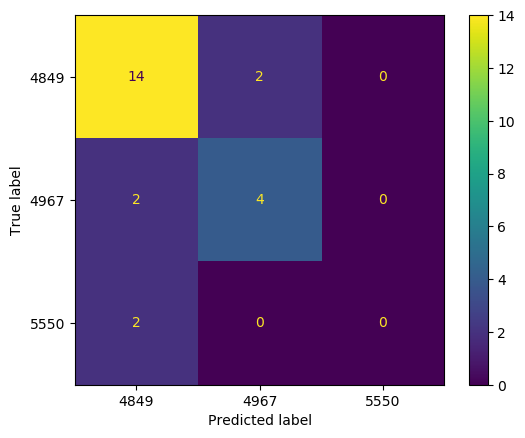

parametri classificatore:  {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 35}

per la sera:


C:\Users\Paolo\anaconda3\envs\DataMining\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


accuracy score =  0.75
accuracy score =  0.5001291822783472


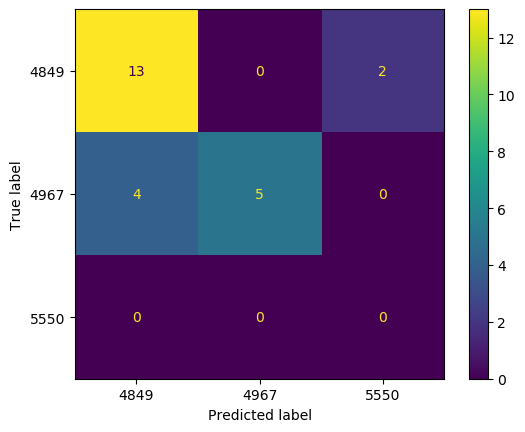

parametri classificatore:  {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 20}


In [13]:
print('per il giorno:')
modello_g=RFclassifier(data, target_g, ['week'])
print('parametri classificatore: ',modello_g.best_params_)

print('\nper la sera:')
modello_s=RFclassifier(data, target_s, ['week'])
print('parametri classificatore: ',modello_s.best_params_)

## commenti
ad essere sincero non mi aspettavo nulla di che visto il modo naif con cui ho costruito il dataframe per l'apprendimento, sperando in un qualche miracolo del machine learnin, però vedendo così i risultati delle matrici di confusione e dei due score sono relativamente soddisfatto dato che non sembrano essere totalmente random
per il codice compare ogni tanto un errore di cui non mi è chiara l'origine anchè perchè non è consistente nel ripetersi